# Creating a fully connected neural network

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import subprocess
from termcolor import colored

In [2]:
# Selection of a GPU
gpu_num = -1

#Loop through avtive GPUs to check for free GPUs
for i in range(7, 0, -1):
    result = subprocess.run(f"nvidia-smi -i {i}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if "No running processes found" in result.stdout:
        gpu_num = i
        break

#If no GPU found, only run nvidia-smi once
first_attempt = True

#Ensure correct input
while 0 > gpu_num or gpu_num > 7:
    #Run nvidia-smi command
    if first_attempt:
        !nvidia-smi
        first_attempt = False

    #Type checking for int between 0 and 7
    try:
        gpu_num = int(input("No Free GPUs Found, manually enter GPU index (0-7): "))
        if 0 <= gpu_num <= 7:
            break
        else:
            print("Error: GPU index must be between 0 and 7.")
    except ValueError:
        print("Error: Please enter a valid integer.")

#Declare device as free device found above  
device = torch.device(f'cuda:{gpu_num}' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:5


In [3]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.fc1=nn.Linear(input_size, input_size*2)
        self.fc2=nn.Linear(input_size*2, input_size)
        self.fc3=nn.Linear(input_size, input_size//4)
        self.outputLayer=nn.Linear(input_size//4, output_size)
        self.relu=nn.ReLU()

    def forward(self, x):
        x=x.view(-1, self.input_size)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        x=self.relu(x)
        x=self.fc3(x)
        x=self.relu(x)
        x=self.outputLayer(x)
        return x

In [4]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience):
    time_start = time()
    model.train()
    epoch_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    final_epoch = -1
    
    for epoch in range(epochs):
        total_loss = 0
        for features, labels in train_loader:
            labels = labels.type(torch.LongTensor)
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)
            outputs = outputs.reshape(outputs.size(0), -1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()           # reset gradient
            loss.backward()                 # automated backwards pass
            optimizer.step()                # take a step

            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)  # Store the average loss

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, labels in val_loader:
                labels = labels.type(torch.LongTensor)
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                outputs = outputs.reshape(outputs.size(0), -1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
        final_epoch = epoch+2

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(colored(f'Early stopping triggered after {epoch+1} epochs.', 'red'))
                break

    # Load the best model state
    model.load_state_dict(best_model_state)

    time_stop = time()
    time_elapsed = time_stop - time_start
    print(f'Elapsed time {round(time_elapsed, 1)} sec.')

    # Plotting the loss over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, final_epoch), epoch_losses, marker='o')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.xticks(range(1, epochs + 1))
    plt.grid()
    plt.show()

    # Plotting the validation error over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, final_epoch), val_losses, marker='o')
    plt.title('Validation Error over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Error')
    plt.xticks(range(1, epochs + 1))
    plt.grid()
    plt.show()

In [5]:
# Testing loop with confusion matrix
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    second_corr = 0
    total = 0
    y_true = []
    y_pred = []
    y_pred_sec = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.reshape(outputs.size(0), -1)
            _, predicted = torch.topk(outputs.data, 3, dim=1)  # predicted = index of maximum probability
            total += labels.size(0)
            correct += (predicted[:,0] == labels).sum().item()
            second_corr += (predicted[:,1] == labels).sum().item()

            # Append true and predicted labels for confusion matrix
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted[:,0].cpu().numpy())
            y_pred_sec.extend(predicted[:,1].cpu().numpy())

    # Calculate and print accuracy
    accuracy = 100 * correct / total
    second_accuracy = 100 * second_corr / total
    print(f'Test Accuracy of the model on the test dataset: {accuracy:.2f}%')
    print(f'Test Accuracy of the model (within two guesses) on the test dataset: {(accuracy + second_accuracy):.2f}%')

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm2 = confusion_matrix(y_true, y_pred_sec)
    plt.figure(figsize=(20, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.1, linecolor='Blue')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    plt.figure(figsize=(20, 14))
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', linewidths=0.1, linecolor='Blue')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Second')
    plt.ylabel('Actual')
    plt.show()

In [6]:
def runModel(file_name, batch_size=512, epochs=25, lrate=0.01, patience=16):
    data = np.load(f"Features/{file_name}")
    features = data['features']
    labels = data['labels']
    remove_labels = list(range(10))

    X = features
    y = labels
    
    print(colored("Device:","blue"))
    print(f"\t{device}\n")
    
    print(colored("Feature Size:","blue"))
    print(f"\t{X.shape[1]}\n")

    print(colored("Number of Images:","blue"))
    print(f"\t{X.shape[0]}\n")
    
    # Get the number of unique classes
    num_classes = len(np.unique(y))
    print(colored("Number of classes:", "blue"))
    print(f"\t{num_classes}\n")

    # Network Specs
    input_size = X.shape[1]  # image data size
    output_size = num_classes

    #instantiate the model, while also defining loss function & optimizer
    model = NeuralNet(input_size=input_size, output_size=output_size).to(device)
    print(colored("Neural Net Definition:", "blue"))
    print(f"{model}\n")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lrate)

    # Split into testing and training data
    X, X_test, y, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)
    
    # Further split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)
    
    X_tensor = torch.tensor(X_train, dtype=torch.float32)  # Ensure dtype is appropriate for your data
    y_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    
    # Create PyTorch Datasets and DataLoaders for training, test, and validation
    train_dataset = TensorDataset(X_tensor, y_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    print(colored("Begin Model Training:", "blue"))
    
    train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs, patience=patience)
    test_model(model, test_loader)

## | Device | Dataset                   | Num Images | Image Size | Epochs | Batch Size | Accuracy (%) | Time (sec) | Model |
|:-------|:--------------------------|:-----------|:-----------|:-------|:-----------|:-------------|:-----------|:------|
| GPU    | Small_Just_Classes_Dataset| 1000       | 256x256    | 15     | 512        | 57.00        | 3.4        | VGG   |
| GPU    | AI_And_Classes            | 185015     | 256x256    | 15     | 512        | 74.42        | 660.8      | VGG   |
| GPU    | AI_And_Classes            | 185015     | 256x256    | 15     | 512        | 77.84        | 46         | ResNet|

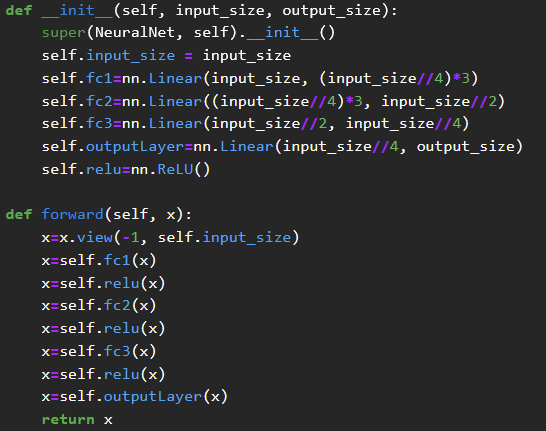

Device:
	cuda:5

Feature Size:
	2048

Number of Images:
	97807

Number of classes:
	11

Neural Net Definition:
NeuralNet(
  (fc1): Linear(in_features=2048, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (outputLayer): Linear(in_features=2048, out_features=11, bias=True)
  (relu): ReLU()
)

Begin Model Training:
Epoch [1/50], Loss: 2.0861
Epoch [2/50], Loss: 1.6100
Epoch [3/50], Loss: 1.3467
Epoch [4/50], Loss: 1.1541
Epoch [5/50], Loss: 0.9576
Epoch [6/50], Loss: 0.7817
Epoch [7/50], Loss: 0.6201
Epoch [8/50], Loss: 0.4872
Epoch [9/50], Loss: 0.3602
Epoch [10/50], Loss: 0.2599
Early stopping triggered after 10 epochs.
Elapsed time 17.8 sec.


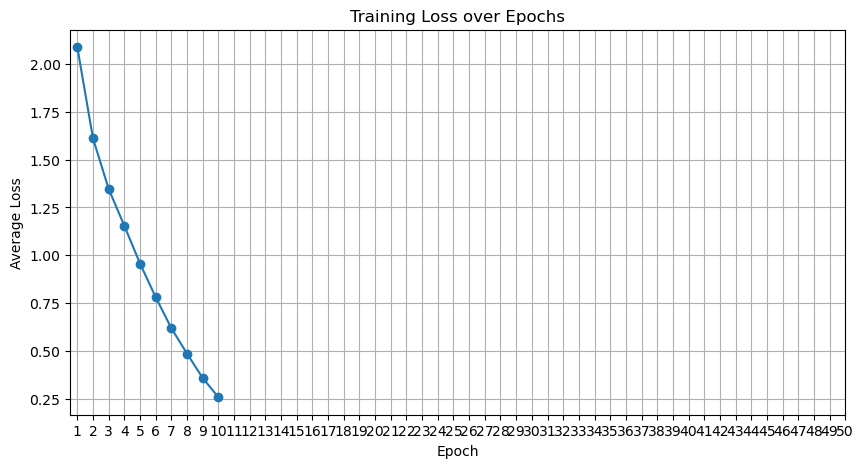

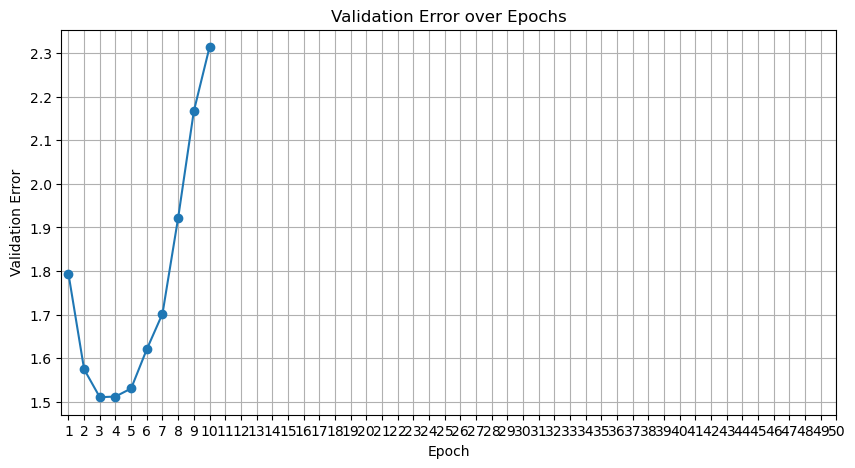

Test Accuracy of the model on the test dataset: 48.37%
Test Accuracy of the model (within two guesses) on the test dataset: 68.14%


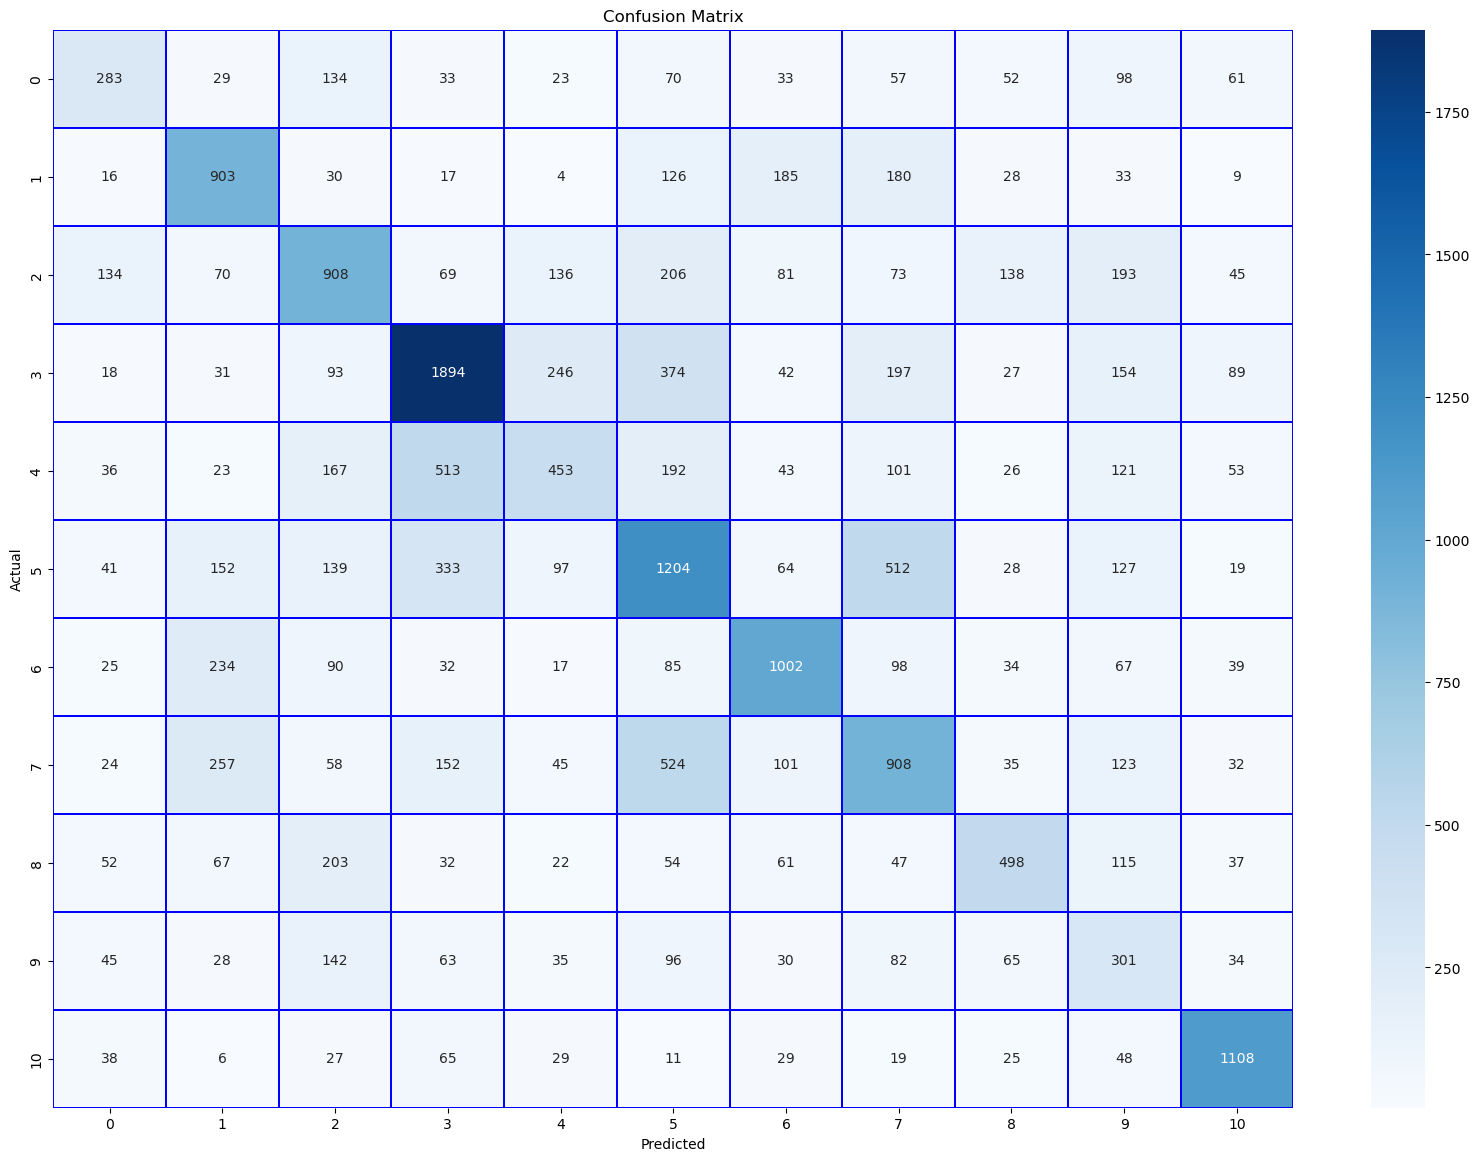

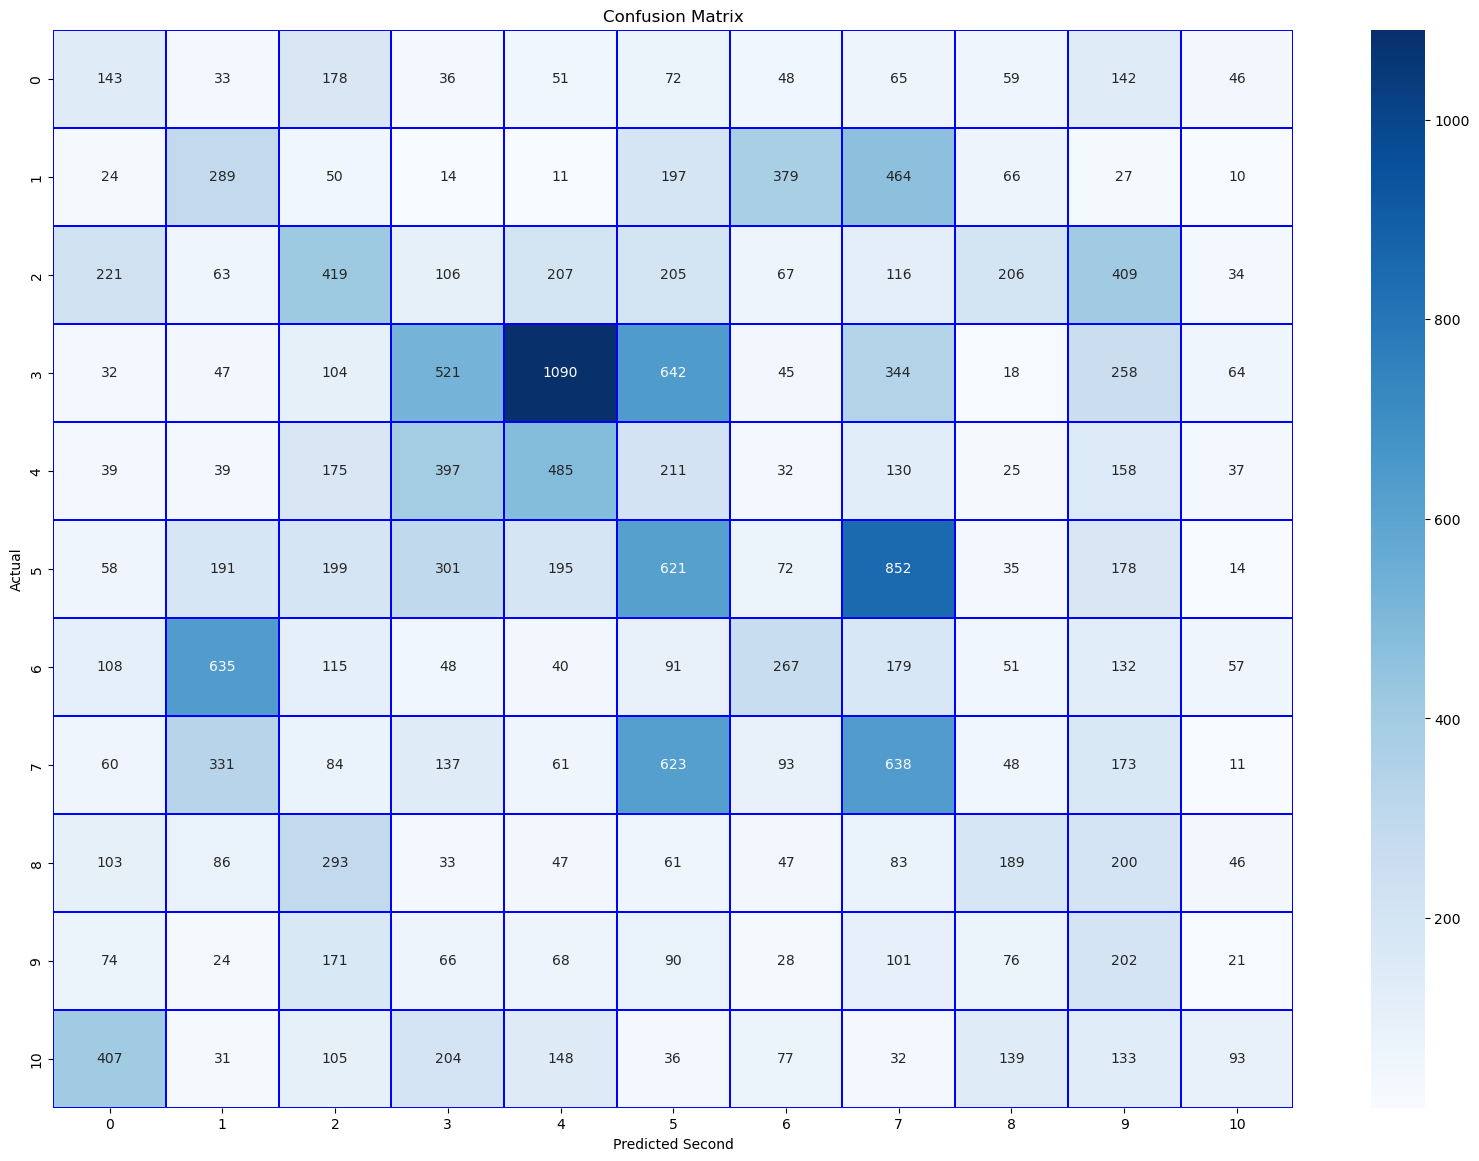

In [7]:
runModel(file_name='256_No_AI_features_resnet.npz', batch_size=500, epochs=50, lrate=0.001, patience=7)